In [1]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
# Where all dataset is there
data_dir = 'C:/code/paddy-disease/training/PlantVillage'

# Training data dir
training_dir = 'C:/code/paddy-disease/training/Train'

# Test data dir
testing_dir = 'C:/code/paddy-disease/training/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))
        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

bacterial_leaf_blight has 438 images
brown_spot has 466 images
healthy has 464 images
leaf_blast has 454 images
leaf_scald has 448 images
narrow_brown_spot has 440 images
Processed 2167 training files.
Processed 543 testing files.


In [4]:
num_classes = 6

def get_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 
    for layer in base_model.layers:
        layer.trainable = False
        
    base_model_ouput = base_model.output
    
    # Adding our own layer 
    x = GlobalAveragePooling2D()(base_model_ouput)
    # Adding fully connected layer
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [5]:
# Get the model
model = get_model()
# Compile it

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Summary of model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [6]:
# Number of classes in dataset
num_classes = 6
batch_size=32
# Get the model
model = get_model()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=20)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_gen.flow_from_directory(training_dir,
                                                     target_size=(224 , 224),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

valid_generator = valid_data_gen.flow_from_directory(testing_dir,
                                                     target_size=(224 , 224),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

from sklearn.utils.class_weight import compute_class_weight

# Set up data generators with class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
# Set up callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.2 ** epoch)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Found 2710 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Epoch 1/30
85/85 [==============================] - 571s 7s/step - loss: 0.5042 - accuracy: 0.8347 - precision: 0.8645 - recall: 0.8125 - auc: 0.9729 - val_loss: 0.2452 - val_accuracy: 0.9106 - val_precision: 0.9255 - val_recall: 0.9010 - val_auc: 0.9929 - lr: 0.0010
Epoch 2/30
85/85 [==============================] - 576s 7s/step - loss: 0.1691 - accuracy: 0.9424 - precision: 0.9469 - recall: 0.9343 - auc: 0.9963 - val_loss: 0.1351 - val_accuracy: 0.9551 - val_precision: 0.9601 - val_recall: 0.9463 - val_auc: 0.9980 - lr: 2.0000e-04
Epoch 3/30
85/85 [==============================] - 579s 7s/step - loss: 0.1293 - accuracy: 0.9594 - precision: 0.9666 - recall: 0.9513 - auc: 0.9983 - val_loss: 0.1221 - val_accuracy: 0.9579 - val_precision: 0.9630 - val_recall: 0.9487 - val_auc: 0.9983 - lr: 4.0000e-05
Epoch 4/30
85/85 [==============================] - 584s 7s/step - loss: 0.1256 - accuracy: 0.9587 - pre

In [7]:
# Unfreeze some layers in the pre-trained model
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model with fine-tuning
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Epoch 1/50
85/85 [==============================] - 959s 11s/step - loss: 0.5784 - accuracy: 0.8391 - precision_1: 0.8656 - recall_1: 0.8011 - auc_1: 0.9673 - val_loss: 38.8014 - val_accuracy: 0.4321 - val_precision_1: 0.4317 - val_recall_1: 0.4309 - val_auc_1: 0.6659 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 939s 11s/step - loss: 0.1501 - accuracy: 0.9502 - precision_1: 0.9543 - recall_1: 0.9472 - auc_1: 0.9964 - val_loss: 0.0935 - val_accuracy: 0.9655 - val_precision_1: 0.9682 - val_recall_1: 0.9631 - val_auc_1: 0.9988 - lr: 2.0000e-04
Epoch 3/50
85/85 [==============================] - 945s 11s/step - loss: 0.1142 - accuracy: 0.9646 - precision_1: 0.9670 - recall_1: 0.9627 - auc_1: 0.9982 - val_loss: 0.0557 - val_accuracy: 0.9792 - val_precision_1: 0.9803 - val_recall_1: 0.9784 - val_auc_1: 0.9997 - lr: 4.0000e-05
Epoch 4/50
85/85 [==============================] - 938s 11s/step - loss: 0.0874 - accuracy: 0.9694 - precision_1: 0.9714 - recall_1: 0.9668 - auc_1

In [8]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/6\assets


INFO:tensorflow:Assets written to: ../saved_models/6\assets


In [9]:
model.save("../paddy.h5")

In [10]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('../paddy.h5')

# Convert the model to TFLite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('paddy_tf.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmplze4flkm\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmplze4flkm\assets


In [14]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="paddy_tf.tflite")
interpreter.allocate_tensors()

interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print("Input shape: ", input_shape)
print("Input type: ", input_dtype)

# Get output shape and type
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']
print("Output shape: ", output_shape)
print("Output type: ", output_dtype)

Input shape:  [  1 224 224   3]
Input type:  <class 'numpy.float32'>
Output shape:  [1 6]
Output type:  <class 'numpy.float32'>


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
image_size=224
# Get the test data
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_gen.flow_from_directory(testing_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical')

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels = test_generator.classes

# Print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_true_labels, y_pred_labels))
print('Confusion Matrix:')
print(confusion_matrix(y_true_labels, y_pred_labels))


Found 2495 images belonging to 6 classes.
78/78 [==============================] - 285s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       0.95      0.96      0.95       430
           2       0.98      0.99      0.99       424
           3       0.96      0.95      0.96       418
           4       1.00      1.00      1.00       410
           5       1.00      1.00      1.00       405

    accuracy                           0.98      2495
   macro avg       0.98      0.98      0.98      2495
weighted avg       0.98      0.98      0.98      2495

Confusion Matrix:
[[408   0   0   0   0   0]
 [  0 411   5  12   0   2]
 [  0   1 421   2   0   0]
 [  0  20   2 396   0   0]
 [  0   0   0   0 410   0]
 [  0   0   0   1   1 403]]


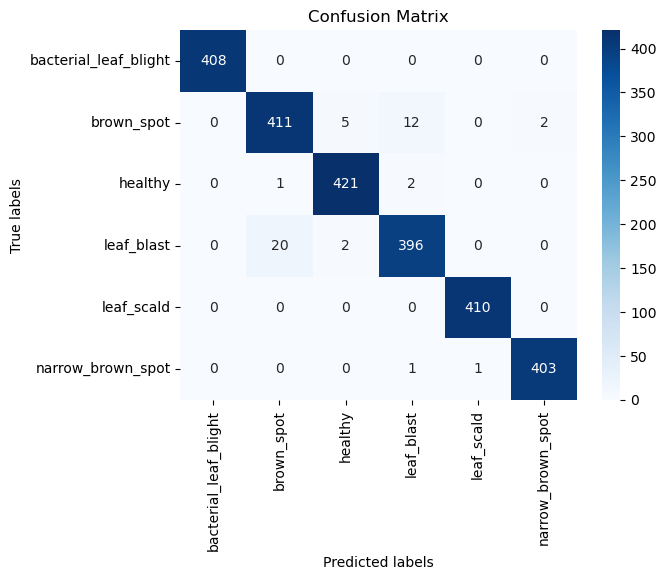

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
confusion_matrix = np.array([[408, 0, 0, 0, 0, 0],
                             [0, 411, 5, 12, 0, 2],
                             [0, 1, 421, 2, 0, 0],
                             [0, 20, 2, 396, 0, 0],
                             [0, 0, 0, 0, 410, 0],
                             [0, 0, 0, 1, 1, 403]])

# Define the class names
class_names = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 85}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1', 'lr'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

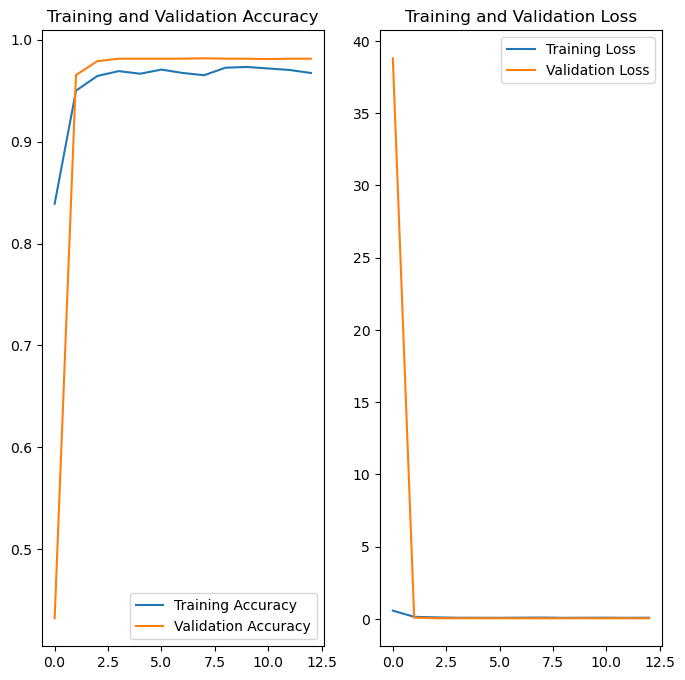

In [26]:
import matplotlib.pyplot as plt
epochs=13
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 159ms/step


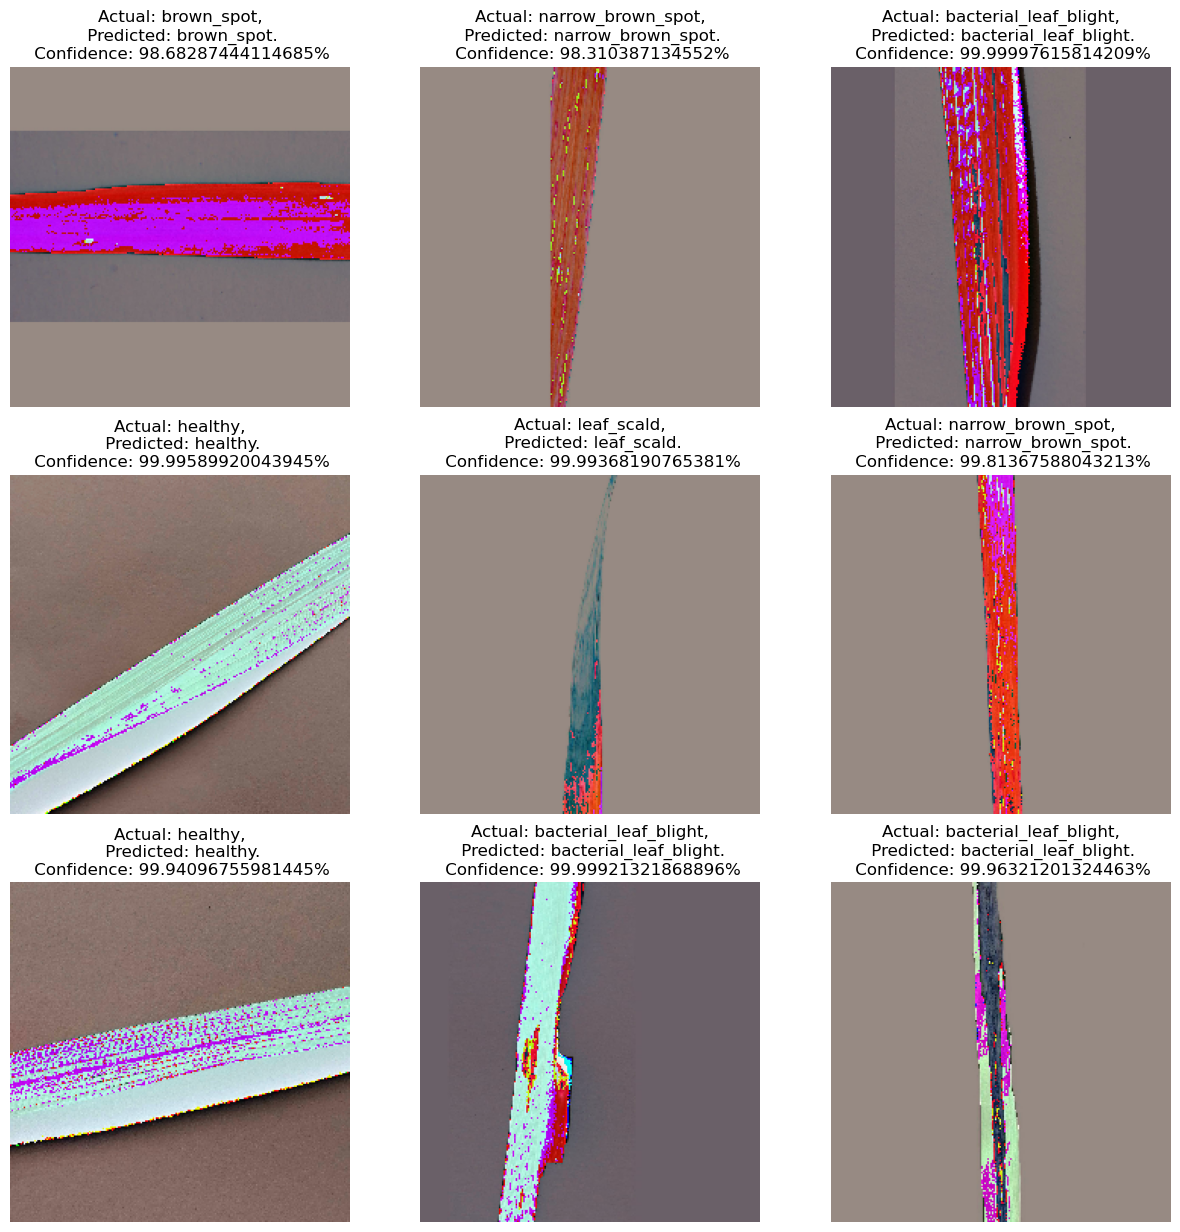

In [28]:
plt.figure(figsize=(15, 15))
images, labels = next(valid_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))

    predicted_class_probs = model.predict(np.expand_dims(images[i], axis=0))[0]
    predicted_class = class_names[np.argmax(predicted_class_probs)]
    confidence = predicted_class_probs[np.argmax(predicted_class_probs)] * 100
    actual_class = class_names[np.argmax(labels[i])]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")
